In [79]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from rosbags.rosbag2 import Reader
from rosbags.serde import deserialize_cdr
from rosbags.highlevel import AnyReader

import numpy as np

In [80]:

def analyze_data(bag_path, topic_name):
    poses_data = {
        'timestamp': [],
        'time_sec': [],
        'position': {
            'x': [],
            'y': [],
            'z': []
        },
        'orientation': {
            'x': [],
            'y': [],
            'z': [],
            'w': []
        },
        'covariance': []
    }
        
    with AnyReader([bag_path]) as reader:
        # Print bag info
        print(f"Bag duration: {reader.duration / 1e9:.2f} seconds")
        print(f"Message count: {reader.message_count}")

        connection = [x for x in reader.connections if x.topic == topic_name]
        
        # Read messages
        for connection, timestamp, rawdata in reader.messages(connections=connection):
            msg = reader.deserialize(rawdata, connection.msgtype)
            
            # Extract pose data
            poses_data['timestamp'].append(timestamp)
            poses_data['time_sec'].append(timestamp / 1e9)

            poses_data['position']['x'].append(msg.pose.pose.position.x)
            poses_data['position']['y'].append(msg.pose.pose.position.y)
            poses_data['position']['z'].append(msg.pose.pose.position.z)
            
            poses_data['orientation']['x'].append(msg.pose.pose.orientation.x)
            poses_data['orientation']['y'].append(msg.pose.pose.orientation.y)
            poses_data['orientation']['z'].append(msg.pose.pose.orientation.z)
            poses_data['orientation']['w'].append(msg.pose.pose.orientation.w)
            
            poses_data['covariance'].append(msg.pose.covariance)

    poses_data['covariance'] = np.array(poses_data['covariance'])
    # print(f"Read {len(poses_data)} pose messages")
    return poses_data


def plot_position_over_time(poses_data):
    plt.plot(
        poses_data['time_sec'],
        poses_data['position']['x']
    )
    plt.grid(True)
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title('x position over time')
    plt.show()


def plot_trajectory(poses_data):
    plt.plot(
        poses_data['position']['x'],
        poses_data['position']['y']
    )
    plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Trajectory over time')
    plt.show()
    

def plot_covariance(ax, poses_data, data_axis, title):
    ax.plot(
        poses_data['time_sec'],
        poses_data['covariance'][:, data_axis]
    )
    ax.set_title(title)
    ax.grid(True)
    ax.set_xlabel('t')
    ax.set_ylabel('Covariance')


def plot_covariances(poses_data):
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))

    plot_covariance(axes[0, 0], poses_data, 0, 'x')
    plot_covariance(axes[0, 1], poses_data, 7, 'y')
    plot_covariance(axes[0, 2], poses_data, 14, 'z')
    plot_covariance(axes[1, 0], poses_data, 21, 'roll')
    plot_covariance(axes[1, 1], poses_data, 28, 'pitch')
    plot_covariance(axes[1, 2], poses_data, 35, 'yaw')

    plt.show()

# First (valid) experiment

In [81]:
# bag_path = Path('../../../datasets/odometry_data/exp2')

# poses_data = analyze_data(bag_path, '/monica/localization_pose')

# plot_position_over_time(poses_data)

# plot_covariances(poses_data)

# Second experiment

In [82]:
# bag_path = Path('../../../datasets/odometry_data/exp3')

# poses_data = analyze_data(bag_path, '/monica/localization_pose')

# plot_trajectory(poses_data)

# plot_covariances(poses_data)

# Experiments with ross and RTAB

In [83]:
# bag_path = Path('../../../datasets/odometry_data/ross_rtab2')

# poses_data = analyze_data(bag_path, '/ross/localization_pose')

# plot_position_over_time(poses_data)

# plot_trajectory(poses_data)

# plot_covariances(poses_data)

# RTAB vs. EKF with Ross

Bag duration: 86.30 seconds
Message count: 2650


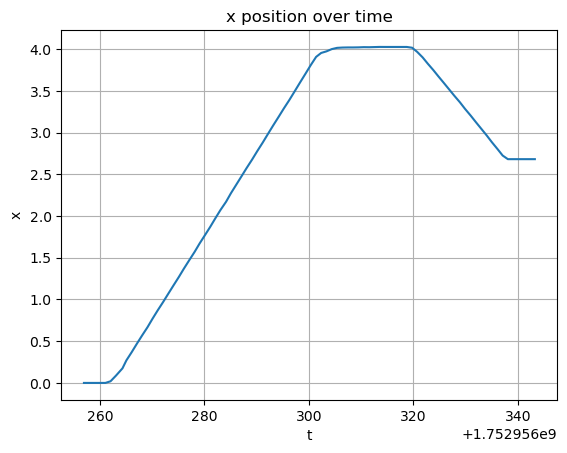

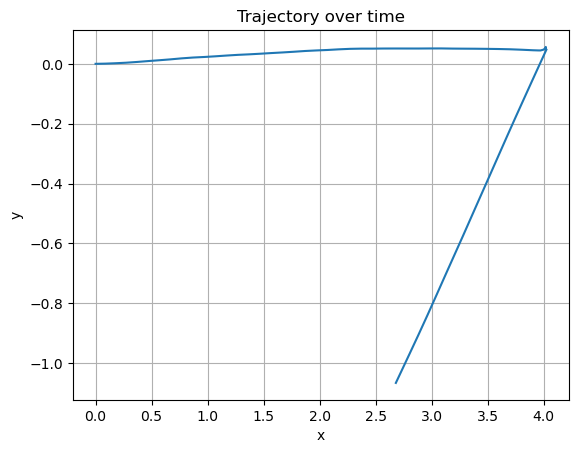

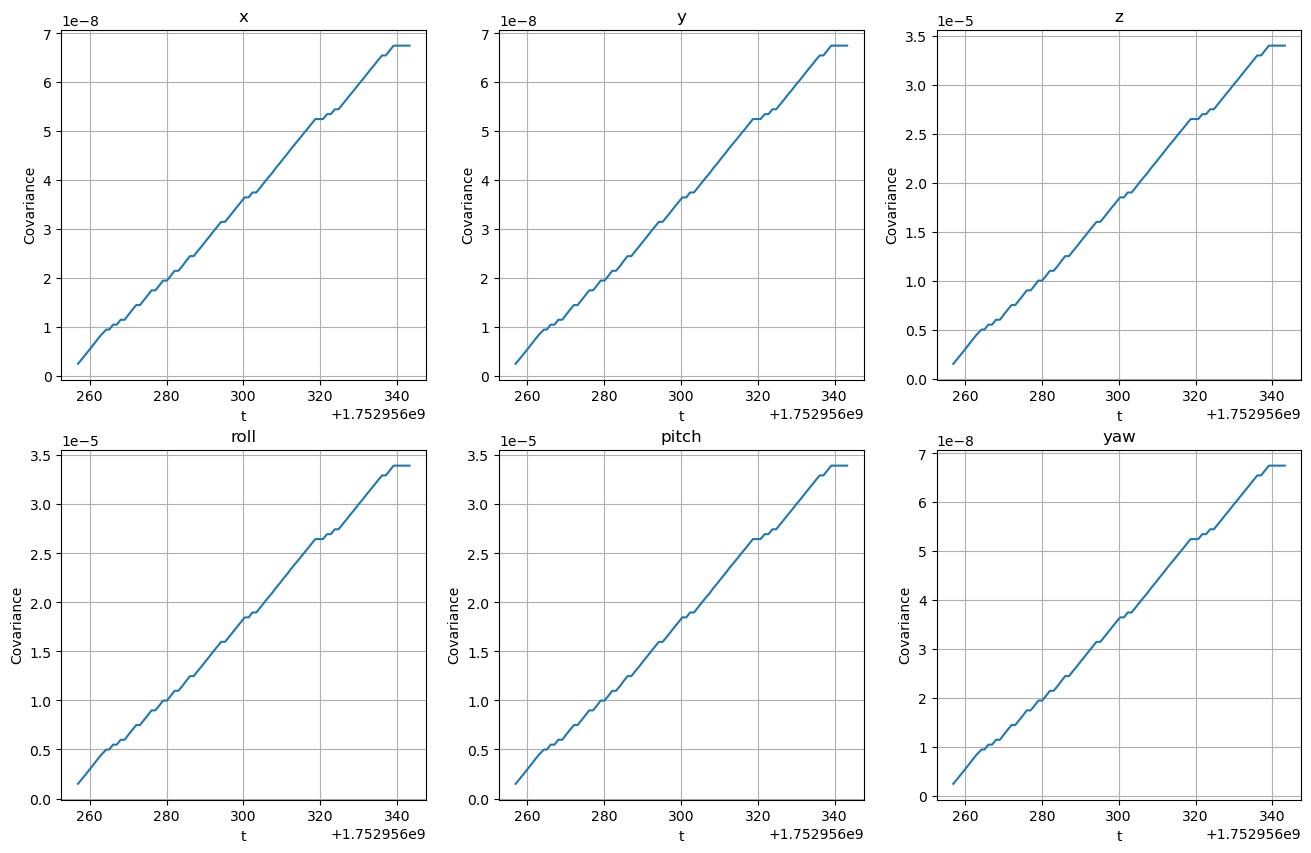

In [84]:
bag_path = Path('../../../datasets/odometry_data/ross_rtab_ekf1')

poses_data = analyze_data(bag_path, '/ross/localization_pose')

plot_position_over_time(poses_data)

plot_trajectory(poses_data)

plot_covariances(poses_data)

Bag duration: 86.30 seconds
Message count: 2650


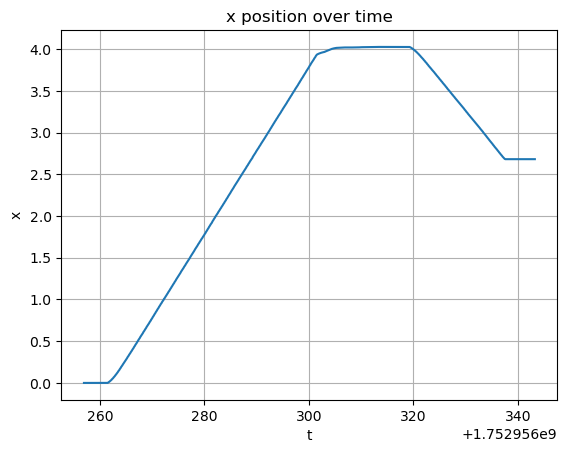

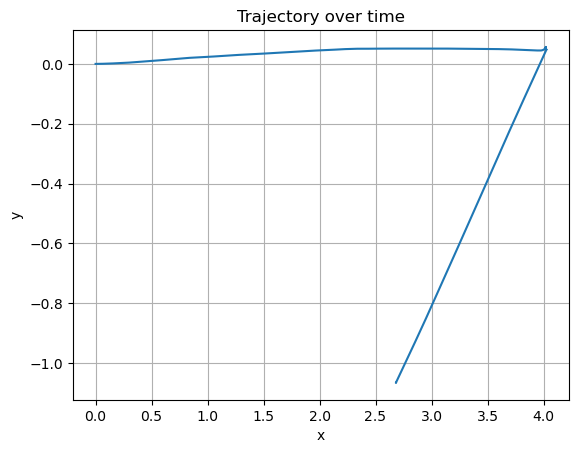

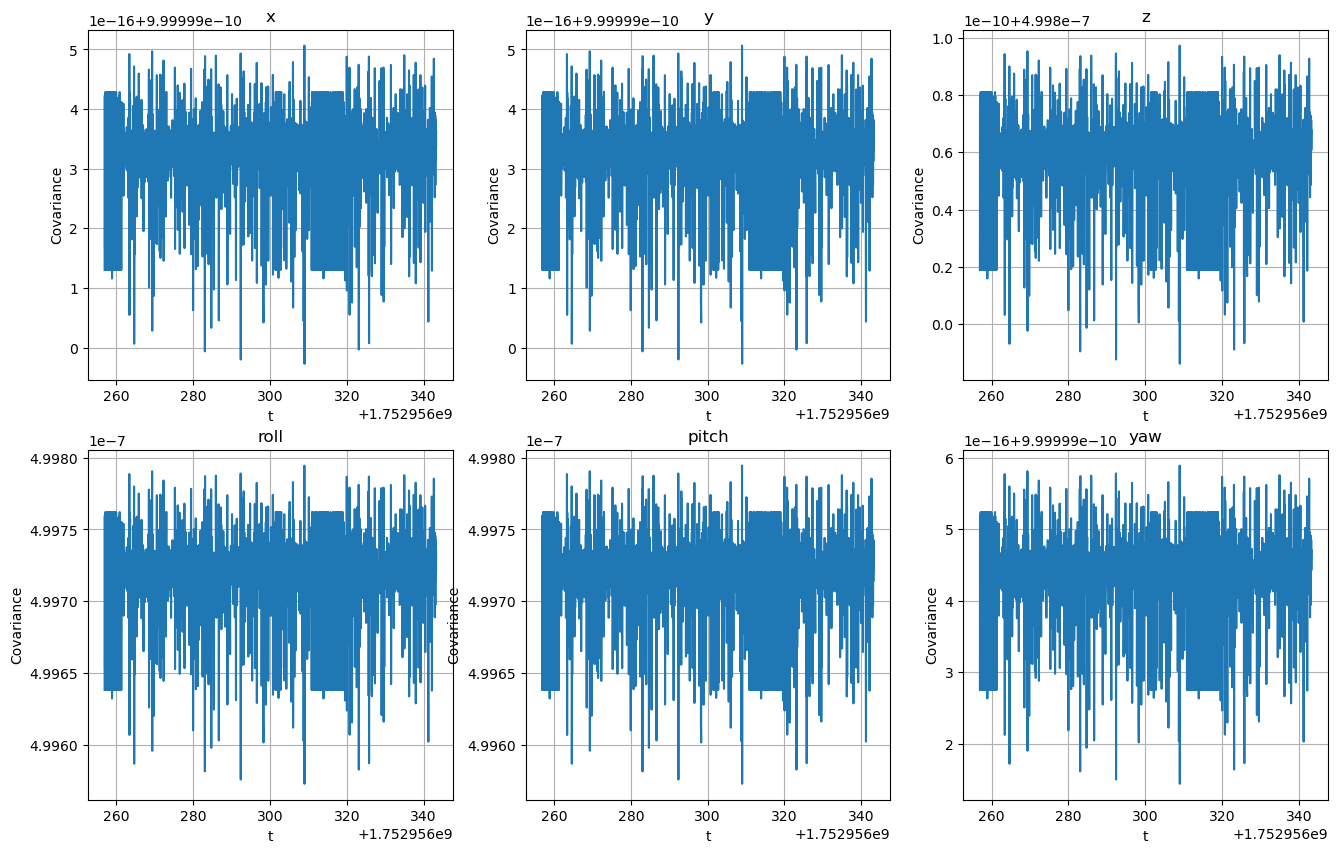

In [85]:
ekf_data = analyze_data(bag_path, '/ross/odometry/filtered')

plot_position_over_time(ekf_data)

plot_trajectory(ekf_data)

plot_covariances(ekf_data)

Bag duration: 86.30 seconds
Message count: 2650


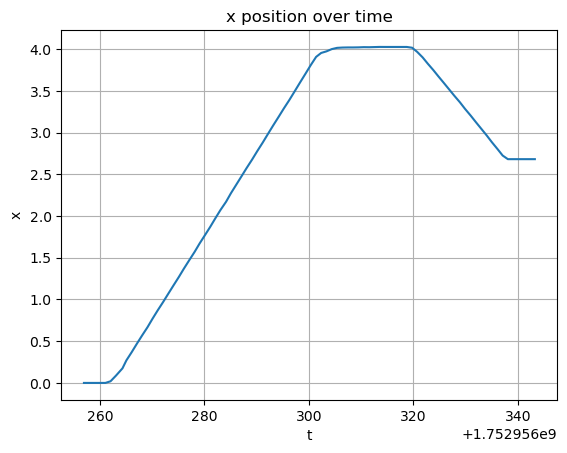

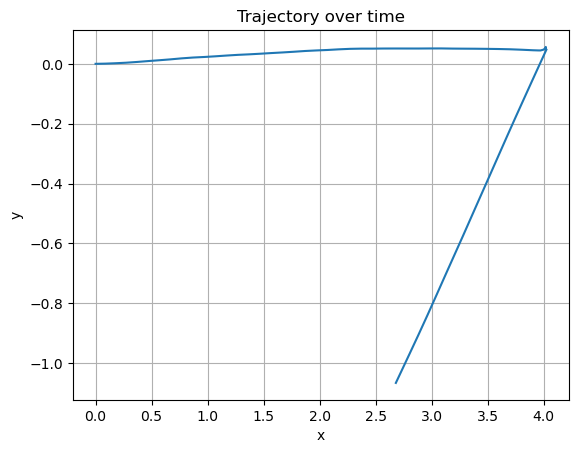

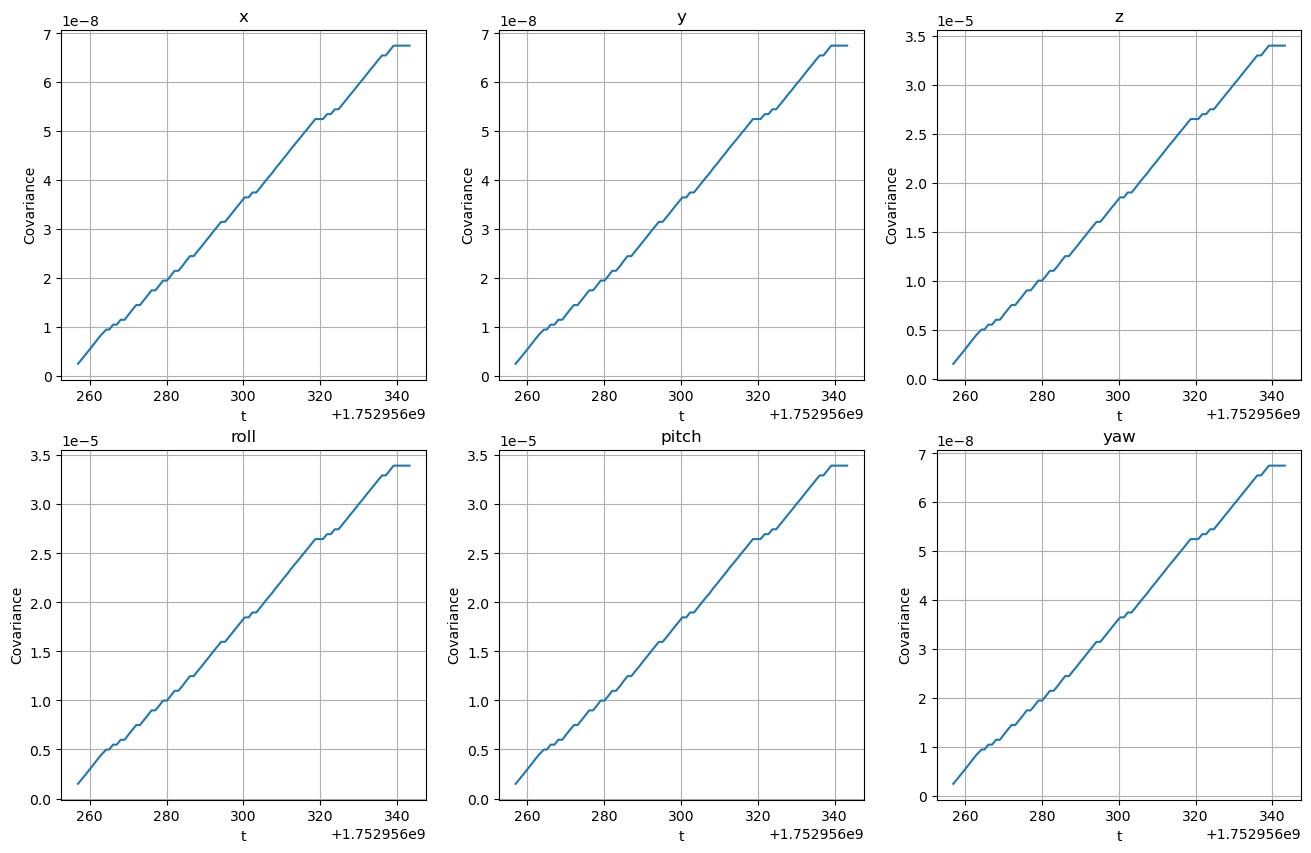

In [86]:
# with IMU
bag_path = Path('../../../datasets/odometry_data/ross_rtab_ekf1')

poses_data = analyze_data(bag_path, '/ross/localization_pose')

plot_position_over_time(poses_data)

plot_trajectory(poses_data)

plot_covariances(poses_data)

Bag duration: 86.30 seconds
Message count: 2650


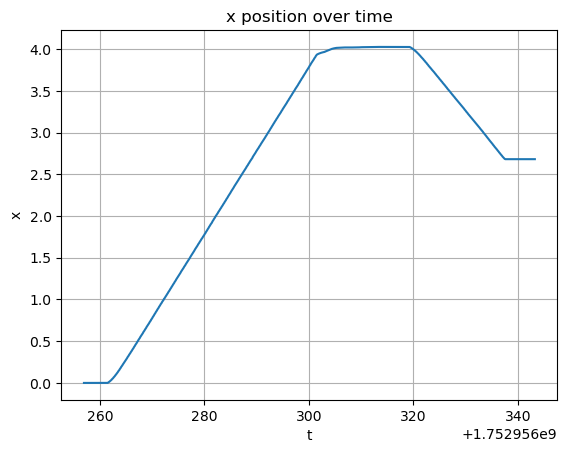

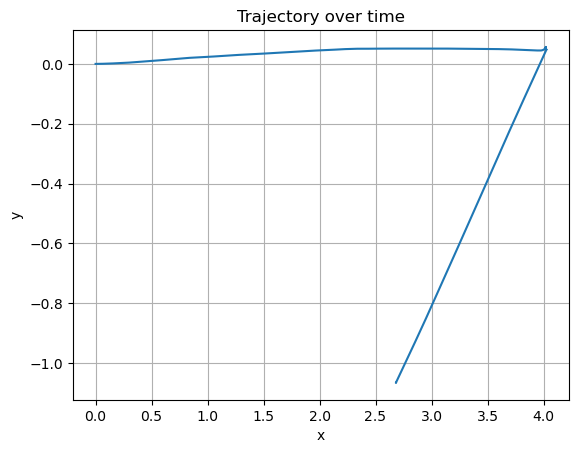

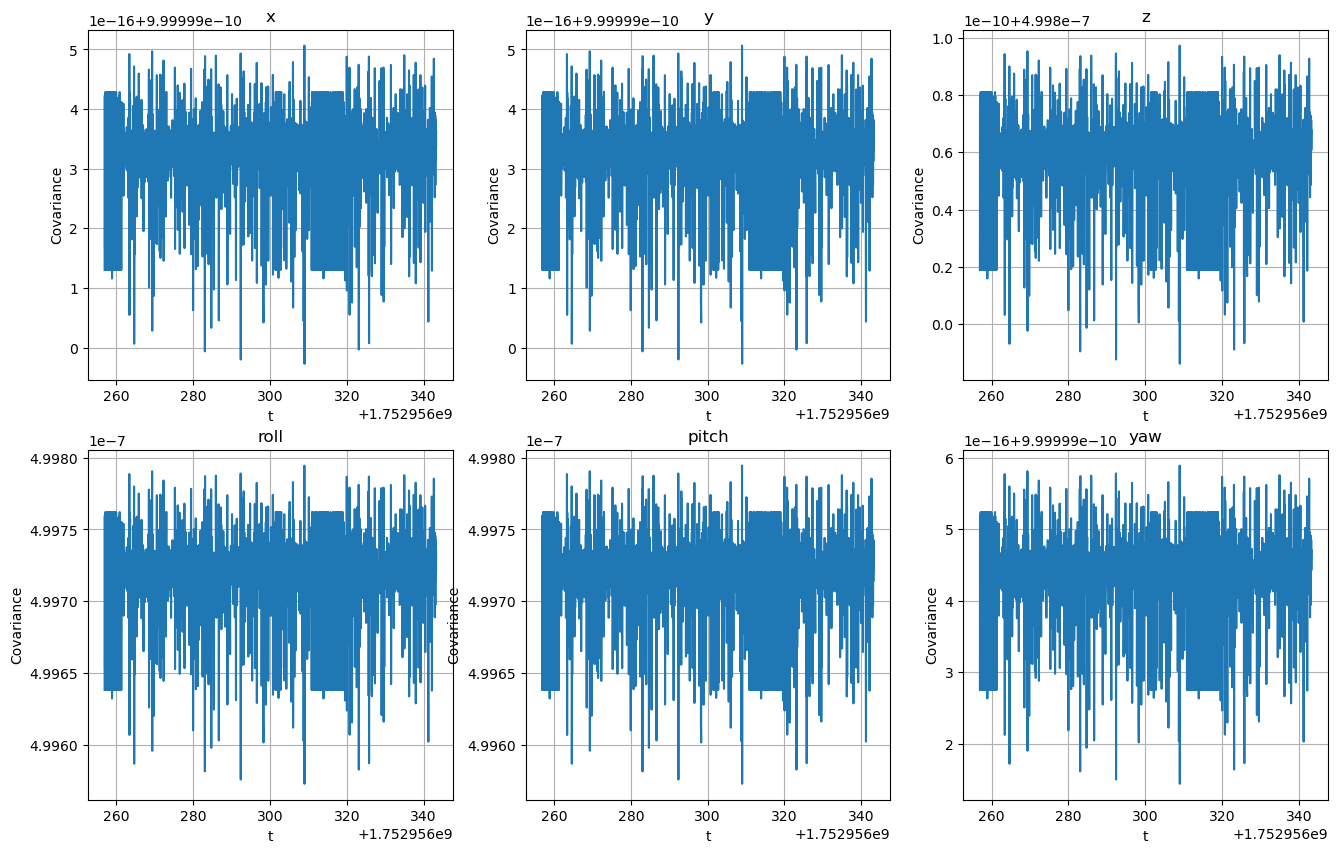

In [87]:
ekf_data = analyze_data(bag_path, '/ross/odometry/filtered')

plot_position_over_time(ekf_data)

plot_trajectory(ekf_data)

plot_covariances(ekf_data)